# K-means кластеризація для сегментації користувачів, заснованої на RFM змінних

Моєю задачею буде сегментація користувачів, виходячи з їх нещодавності та частоти покупок, а також сум витрат на них. Буду використовувати набір даних із наступного джерела: https://archive.ics.uci.edu/ml/datasets/online+retail 

0.Імпорт бібліотек.

In [1]:
!pip install feature-engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from datetime import datetime,date
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.0/290.0 KB 9.6 MB/s eta 0:00:00


1.Завантаження набору даних із файлу. 

In [2]:
from google.colab import files
uploades = files.upload()


Saving Online Retail.xlsx to Online Retail.xlsx


In [3]:
df_raw_data = pd.read_excel('Online Retail.xlsx')
df_raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Підготовка даних

 2.1 Проведу невеликий аналіз даних.


Я працюватиму з даними, які містить усі транзакції, здійснені з 01/12/2010 по 09/12/2011 для роздрібної онлайн-магазину, який в основному продає унікальні подарунки на всі випадки життя. Багато клієнтів компанії - оптовики.

Отримані дані містять 8 атрибутів (datetime64(1), float64(2), int64(1), object(4)) і 541908 записів. Три колонки є ідентифікаторами, а саме:InvoiceNo - число (індифікаційний номер), яке присвоюється кожній транзакції, StockCode - номер, який присвоюється кожному індивідуальному продукту , CustomerID - індифікаційний номер клієнта. Два кількісні числові атрибути: Quantity - кількість кожного продукту на транзакцію і UnitPrice - ціна продукту. Description - опис продукту, Country - країна де проживає клієнт. InvoiceDate - дата проведення транзакції. Ми матимемо справу з відсутніми значеннями: в колонці CustomerID 25% відсутніх значень. При аналізі квартилів бачимо, що числові дані розподілені нерівномірно і великі викиди мінімальних і максимальних значень, більше того є відємні значення. 



In [4]:
df_raw_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


<Axes: >

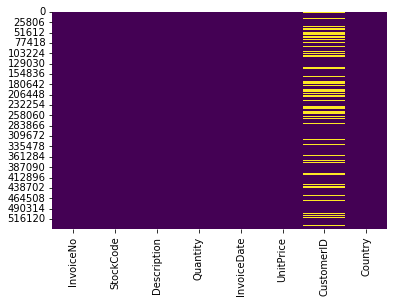

In [6]:
sns.heatmap(df_raw_data.isnull(),cbar=False,cmap='viridis')

In [7]:
df_raw_data.describe(include = [np.number])

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
print(df_raw_data[df_raw_data.select_dtypes(include=['object']).columns].nunique())

InvoiceNo      25900
StockCode       4070
Description     4223
Country           38
dtype: int64


  Змінна  Quantity відповідає за кількість кожного продукту в транзакції, а UnitPrice - відповідає ціні продукту в фунтах стерлінгів. Відємні значення можуть означати або 1) просту описку; або 2) зроблене замовлення але скасоване з певних причин (відсутності товару або зміна думки клієнта). У більшості випадків це справді другий варіант, що відповідає за скасування замовлення. 

На мою думку, виходячи з задачі сигментації, необхідно видалити від'ємні значення, оскільки, з від'ємними значеннями важче працювати. Наприклад, якщо клієнт зробив замовлення і скасував, то потрібно врахувати це. А саме - відняти від всієї суми ціни за продукт  суму ціни за цей товар зі скасованого замовлення. При роботі з кількістю транзакцій згідно подібних прикладів роботи з транзакціями, які я переглянула, виникає більше труднощів, особливо якщо враховувати можливість того, що транзакцію могли скасувати не в той самий день, що робили замовлення. Ну і чисто логічно, створення замовлення вже говоритиме про зацікавленість клієнта в даному продукті, що є важливим при сигментації клієнтів. Тому, в даному випадку буде простіше не враховувати від'ємні значення.

In [9]:
df_update= df_raw_data[(df_raw_data['UnitPrice']>0) & (df_raw_data['Quantity']>0)]
df_update.describe(include = [np.number])

,Quantity,UnitPrice,CustomerID
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


2.2.Виведу відсоток відсутніх значень у кожній із колонок.

In [10]:
missing_perc = df_update.isnull().sum() * 100 / len(df_update)
missing_data_df = pd.DataFrame({'column_name': df_update.columns,
                                 'percent_missing': missing_perc })
missing_perc.round(2)

InvoiceNo       0.00
StockCode       0.00
Description     0.00
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.94
Country         0.00
dtype: float64

2.3. Видалю рядки з відсутніми значеннями.

In [11]:
df_update = df_update.dropna()
df_update.isnull().sum() * 100 / len(df_update)


InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

2.4. Виведу значення змінної Country, відсортувавши їх за відсотком присутності в даних.


In [12]:
perc_country = df_update.groupby('Country')['InvoiceNo'].apply (lambda x: x.count()*100/ df_update.shape[0]).sort_values(ascending=False)
conition_statement = perc_country[perc_country > 1]
a =list(conition_statement.index)
perc_country

Country
United Kingdom          89.051332
Germany                  2.272019
France                   2.096340
EIRE                     1.818621
Spain                    0.624303
Netherlands              0.592886
Belgium                  0.510450
Switzerland              0.462698
Portugal                 0.367444
Australia                0.297072
Norway                   0.269174
Italy                    0.190508
Channel Islands          0.187994
Finland                  0.172161
Cyprus                   0.154316
Sweden                   0.113350
Austria                  0.100029
Denmark                  0.095505
Poland                   0.082939
Japan                    0.080677
Israel                   0.062330
Unspecified              0.061324
Singapore                0.055795
Iceland                  0.045742
USA                      0.044988
Canada                   0.037951
Greece                   0.036443
Malta                    0.028149
United Arab Emirates     0.017090
Europe

2.5.У наборі даних є значення змінної Country, яке зустрічається найчастіше.
Відфільтрую дані лише до тих записів, які мають значення змінної Country. 

In [13]:
df_work = df_update[df_update['Country'] == 'United Kingdom']
df_work.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


2.6. Створю стовпець Date із значень у стовпці InvoiceDate. Стовпець Date буде містити дату у форматі рік-місяць-день.

In [14]:
df_work['date'] = pd.to_datetime(df_update.loc[:,'InvoiceDate']).dt.date
df_work.head(20)


<ipython-input-14-2a61a48a6c8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work['date'] = pd.to_datetime(df_update.loc[:,'InvoiceDate']).dt.date


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,2010-12-01
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,2010-12-01
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,2010-12-01
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,2010-12-01
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,2010-12-01


Отже, на даний момент є всі необхідні дані для вирішення задачі:
- Customer ID
- Unit Price
- Quantity
- Invoice Date

## RFM

Давність-частота-грошовий вираз (Recency-Frequency-Monetary)
    
    
RFM-аналіз дозволяє сегментувати клієнтів за частотою та вартістю покупок та визначати тих клієнтів, які витрачають найбільше грошей.

* Давність - скільки часу пройшло з того часу, як клієнт щось купив у нас.
* Частота - як часто клієнт купує у нас.
* Грошовий вираз - загальна вартість покупок, здійснених покупцем.

Логічно припустити з опису вище, що дані мають бути згруповані за клієнтами. Інакше немає сенсу виводити Recency та Частоту.

3.1.Визначу останню дату транзакції у наборі даних. Щоб розподіл recency розпочинався з нуля, за дату "сьогодні" візьму дату останньої транзакції в наборі даних.

In [15]:
NOW =  df_work['date'].max()
NOW

datetime.date(2011, 12, 9)

### Recency

3.2.У змінну R_df запишу recency dataframe, що складатиметься з колонок CustomerID, Last_Purchase_Date та Recency,
де     
   - Last_Purchase_Date - це дата останньої покупки клієнта;
   - Recency - скільки днів минуло з дати останньої покупки клієнта до NOW.

In [16]:
last_purchase_date = df_work.groupby('CustomerID')['date'].max()
recency = (NOW - last_purchase_date)/ np.timedelta64(1, 'D')
R_df = pd.DataFrame(data={'CustomerID':last_purchase_date.index, 'Last_Purchase_Date': last_purchase_date, 'Recency':recency}).reset_index(drop=True)
R_df.head()



,CustomerID,Last_Purchase_Date,Recency
0,12346.0,2011-01-18,325.0
1,12747.0,2011-12-07,2.0
2,12748.0,2011-12-09,0.0
3,12749.0,2011-12-06,3.0
4,12820.0,2011-12-06,3.0


### Frequency - Monetary

3.3.Створю Frequency - Monetary dataframe у змінній FM_df.  
Датафрейм буде містити
- CustomerID - ідентифікатор клієнта
- Frequency - кількість покупок клієнта (кількість унікальних інвойсів)
- Monetary - скільки грошей у магазині витратив клієнт

In [17]:
frequency  = df_work.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()

df_work['Amount'] = df_work['Quantity']*df_work['UnitPrice']
monetary = df_work.groupby('CustomerID')['Amount'].sum()
monetary = monetary.reset_index()
FM_df = pd.merge(frequency,monetary, on='CustomerID',how='inner').reset_index(drop=True)
FM_df.columns = ['CustomerID','Frequency','Monetary']
FM_df.head()

<ipython-input-17-ca966cd126c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work['Amount'] = df_work['Quantity']*df_work['UnitPrice']


,CustomerID,Frequency,Monetary
0,12346.0,1,77183.60
1,12747.0,103,4196.01
2,12748.0,4595,33719.73
3,12749.0,199,4090.88
4,12820.0,59,942.34


### RFM
3.4.Створю RFM_df, який буде об'єднанням R_df та FM_df за ідентифікатором клієнта.

In [18]:
RFM_df = R_df.join(FM_df.set_index("CustomerID"), on="CustomerID")
RFM_df.head(20)

,CustomerID,Last_Purchase_Date,Recency,Frequency,Monetary
0,12346.0,2011-01-18,325.0,1,77183.60
1,12747.0,2011-12-07,2.0,103,4196.01
2,12748.0,2011-12-09,0.0,4595,33719.73
3,12749.0,2011-12-06,3.0,199,4090.88
4,12820.0,2011-12-06,3.0,59,942.34
5,12821.0,2011-05-09,214.0,6,92.72
6,12822.0,2011-09-30,70.0,46,948.88
7,12823.0,2011-09-26,74.0,5,1759.50
8,12824.0,2011-10-11,59.0,25,397.12
9,12826.0,2011-12-07,2.0,91,1474.72


## K-means для RFM сегментації

K-means дає кращий результат за наступних умов:
- Розподіл даних не спотворений (тобто немає довгих хвостів)
- Дані стандартизовані (тобто середнє значення 0 та стандартне відхилення 1).

4.1.Побудую діаграми розподілу даних  для колонок Recency, Frequency і Monetary RFM_df.
Виведу коефіцієнт асиметрії кожної з колонок.

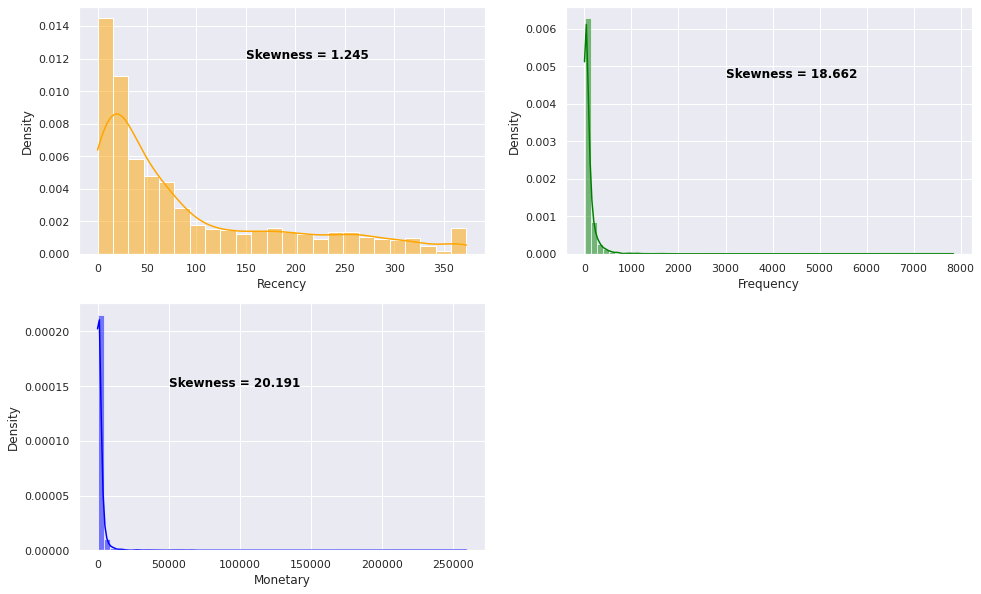

In [19]:
sns.set(rc={"figure.figsize": (16, 10)})

plt.subplot(2,2,1)
sns.histplot(x=RFM_df['Recency'], color="orange", stat='density', kde=True)
plt.text(150, 0.012, f"Skewness = {scipy.stats.skew(RFM_df['Recency'], axis = 0, bias = True):.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.subplot(2,2,2)
sns.histplot(x=RFM_df['Frequency'], color="green", stat='density',bins=60, kde=True)
plt.text(3000, 0.0047, f"Skewness = {scipy.stats.skew(RFM_df['Frequency'], axis = 0, bias = True):.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.subplot(2,2,3)
sns.histplot(x=RFM_df['Monetary'], color="blue", stat='density', bins=60, kde=True)
plt.text(50000, 0.00015, f"Skewness = {scipy.stats.skew(RFM_df['Monetary'], axis = 0, bias = True):.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()



Дані сильно зміщені, тому потрібно здійснити над ними log перетворення, щоб зменшити асиметрію кожної змінної.

4.2.Над кожною зі змінних 'Recency', 'Frequency', 'Monetary' виконаю перетворення log(x+1).   
Додам константу, оскільки log перетворення вимагає, щоб усі значення були позитивними.


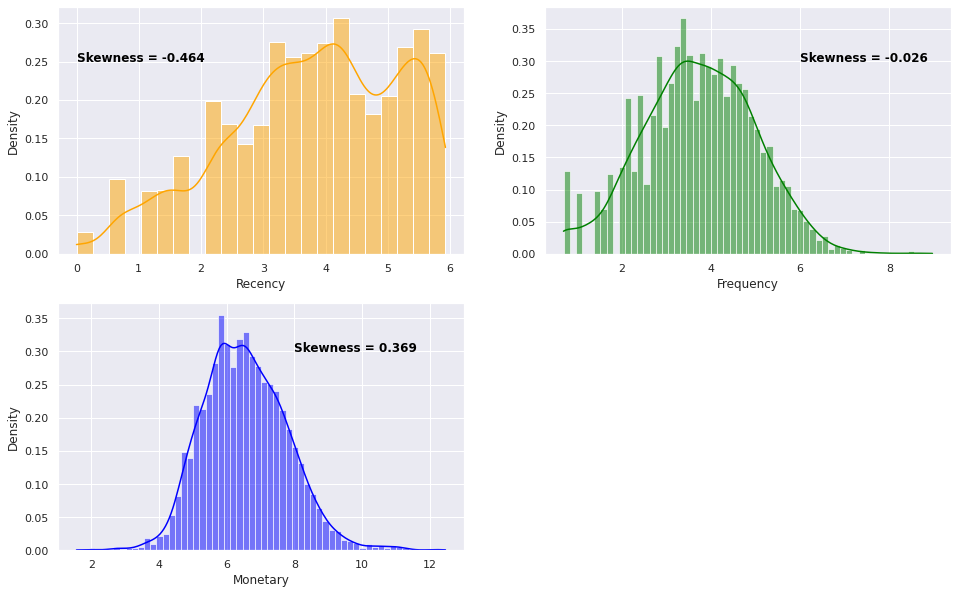

In [20]:
RFM_df_log = RFM_df.copy()
RFM_df_log['Recency'] = np.log1p(RFM_df['Recency'])
RFM_df_log['Frequency'] = np.log1p(RFM_df['Frequency'])
RFM_df_log['Monetary'] = np.log1p(RFM_df['Monetary'])


sns.set(rc={"figure.figsize": (16, 10)})

plt.subplot(2,2,1)
sns.histplot(x=RFM_df_log['Recency'], color="orange", stat='density', kde=True)
plt.text(0, 0.25, f"Skewness = {scipy.stats.skew(RFM_df_log['Recency'], axis = 0, bias = True):.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.subplot(2,2,2)
sns.histplot(x=RFM_df_log['Frequency'], color="green", stat='density',bins=60, kde=True)
plt.text(6, 0.3, f"Skewness = {scipy.stats.skew(RFM_df_log['Frequency'], axis = 0, bias = True):.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.subplot(2,2,3)
sns.histplot(x=RFM_df_log['Monetary'], color="blue", stat='density', bins=60, kde=True)
plt.text(8, 0.3, f"Skewness = {scipy.stats.skew(RFM_df_log['Monetary'], axis = 0, bias = True):.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()


4.3.З візуалізації видно, що в нас все одно залишилися хвости. Приберу їх з використанням техніки **Winsorizing**.    




У змінній windsoriser створю екземпляр класу Winsorizer зі значеннями змінних 'tail='both'', 'fold=2', а в 'variables' передам назви змінних, які хочу перетворити.


In [21]:

windsoriser = Winsorizer(tail='both', fold=2, variables=['Recency', 'Frequency', 'Monetary'])
windsoriser.fit(RFM_df_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

Викликаю трансформацію:

Skewness = -0.348


,CustomerID,Last_Purchase_Date,Recency,Frequency,Monetary
0,12346.0,2011-01-18,5.786897,1.201406,9.033167
1,12747.0,2011-12-07,1.098612,4.644391,8.342128
2,12748.0,2011-12-09,1.034417,6.241314,9.033167
3,12749.0,2011-12-06,1.386294,5.298317,8.316760
4,12820.0,2011-12-06,1.386294,4.094345,6.849427
...,...,...,...,...,...
3915,18280.0,2011-03-07,5.627621,2.397895,5.201806
3916,18281.0,2011-06-12,5.198497,2.079442,4.404522
3917,18282.0,2011-12-02,2.079442,2.564949,5.187665
3918,18283.0,2011-12-06,1.386294,6.241314,7.647729


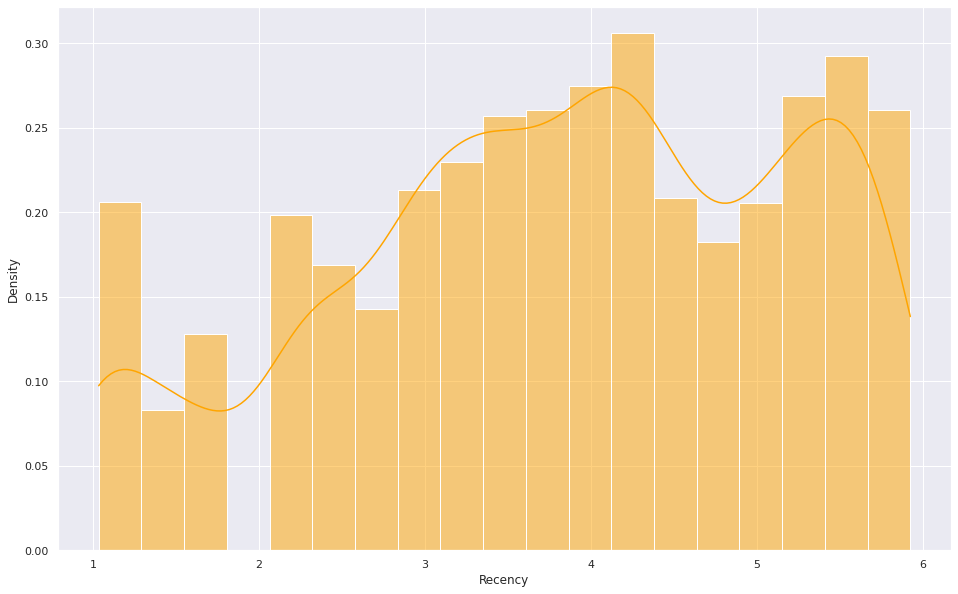

In [22]:
transf_RFM = windsoriser.transform(RFM_df_log)
sns.histplot(x=transf_RFM['Recency'], color="orange", stat='density', kde=True)
print(f"Skewness = {scipy.stats.skew(transf_RFM['Recency'], axis = 0, bias = True):.3f}")
transf_RFM 

4.4. Стандартизую  RFM змінні те, щоб середнє було 0, а стандартне відхилення дорівнювало 1. 

In [23]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(transf_RFM[['Recency', 'Frequency', 'Monetary']])


4.5. Знайду оптимальну кількість кластерів за допомогою Elbow Method.
Запущу KMeans кластеризацію підготовлених стандартизованих RFM даних з параметром K від 1 до 10 включно.


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

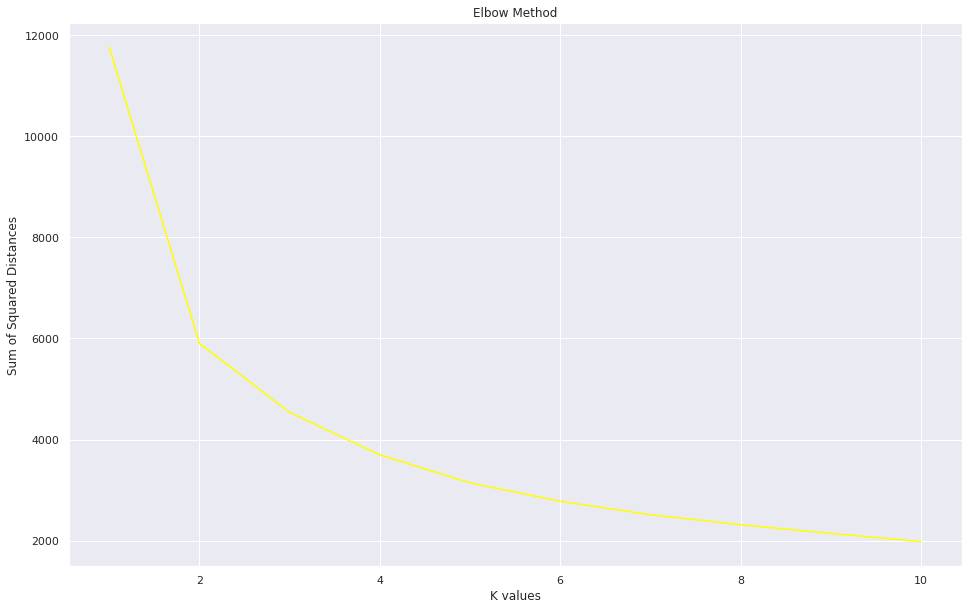

In [24]:
k = range(1,11)
sum_of_sqr_dist = []

for item in k:
    model = KMeans(n_clusters=item).fit(scaled_data)
    sum_of_sqr_dist.append(model.inertia_)
plt.plot(k, sum_of_sqr_dist, 'yellow')
plt.xlabel('K values')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

Значення кластера, при якому зменшення значення inertia стає постійним, можна вибрати як правильне значення кластера для наших даних.
Спробую використовувати значення К від 3 до 5.

4.6.Створю функцію, яка прийматиме набір даних для навчання (стандартизовані дані), значення К та набір даних з оригінальними (до стандартизації) значеннями (назвем його original_df_rfm).Основною її метою буде за допомогою візуалізацій зрозуміти, яка кількість кластерів оптимальна.

Усередині функції будемо реалізовувати наступні пункти:
1. Навчити на стандартизованих даних Kmeans з кількістю кластерів К, що є аргументом функції.
2. Отримати ідентифікатори кластерів (лейбли).
3. Створити новий датафрейм як копію original_df_rfm.
4. До набору даних, отриманого в п.3, додати колонку зі значенням кластера для даного рядка.
5. Виконати зменшення розмірності за допомогою TSNE (можете спробувати замість TSNE використовувати PCA, і візуально порівняти результати).
6. Відобразити результати кластеризації.



In [25]:
from sklearn.manifold import TSNE

def fit_visualize_kmeans(stand_df, clusters_number, original_df_rfm):
  kmeans = KMeans(n_clusters=clusters_number, random_state=0)
  kmeans.fit(stand_df)
  
  cluster_labels =  kmeans.labels_
        
# Копія original_df_rfm з додатковою колонкою, яка містить лейбли кластерів
  df_temp = original_df_rfm.copy()
  df_temp['labels'] = cluster_labels
    
# Задаємо TSNE
  model = TSNE(random_state=1)
  transformed = model.fit_transform(df_temp)

# Візуалізуємо результати TSNE трансформації
  plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
  params = dict(
        x=transformed[:,0], 
        y=transformed[:,1],
        hue=cluster_labels, 
        style=cluster_labels, 
        palette="Set1"
    )
  sns.scatterplot(**params)
  return df_temp

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


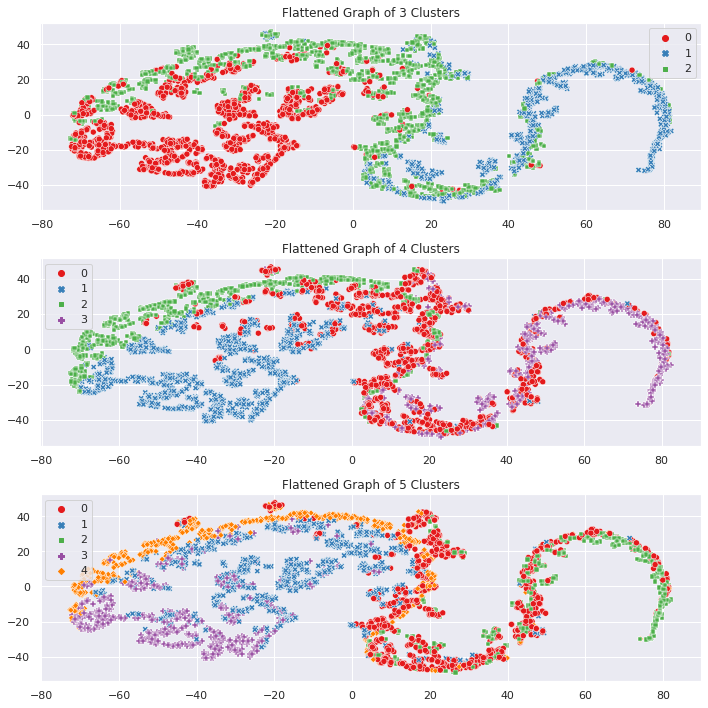

In [26]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = fit_visualize_kmeans(scaled_data, 3, RFM_df[['Recency', 'Frequency', 'Monetary']])

plt.subplot(3, 1, 2)
df_rfm_k4 = fit_visualize_kmeans(scaled_data, 4, RFM_df[['Recency', 'Frequency', 'Monetary']])

plt.subplot(3, 1, 3)
df_rfm_k5 = fit_visualize_kmeans(scaled_data, 5, RFM_df[['Recency', 'Frequency', 'Monetary']])

plt.tight_layout()


In [ ]:
df_rfm_k3

,Recency,Frequency,Monetary,labels
0,325.0,1,77183.60,0
1,2.0,103,4196.01,1
2,0.0,4595,33719.73,1
3,3.0,199,4090.88,1
4,3.0,59,942.34,1
...,...,...,...,...
3915,277.0,10,180.60,0
3916,180.0,7,80.82,0
3917,7.0,12,178.05,2
3918,3.0,756,2094.88,1


4.7.Збудую додатково [Snake plots](https://www.marketingprofs.com/tutorials/snakeplot.asp), які часто використовують у маркетингових аналізах. 

Напишу функцію для її реалізації, яка виконуватиме наступні підзадачі:

1. Створюватиме датафрейм normalised_df_rfm, який містить оригінальні CustomerID, стандартизовані значення Recency, Frequency, Monetary та номер кластера.
2. Візуалізуватиме датафрейм.


In [27]:
def snake_plot(cluster_df, custID, scaled_df):
    normalised_df_rfm = pd.DataFrame(scaled_df,
                                    columns=['Recency', 'Frequency',	'Monetary'])
    normalised_df_rfm['Cluster'] = cluster_df['labels']
    normalised_df_rfm['CustomerID'] = custID
    # "Расплавляем" данные в длинный формат
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')

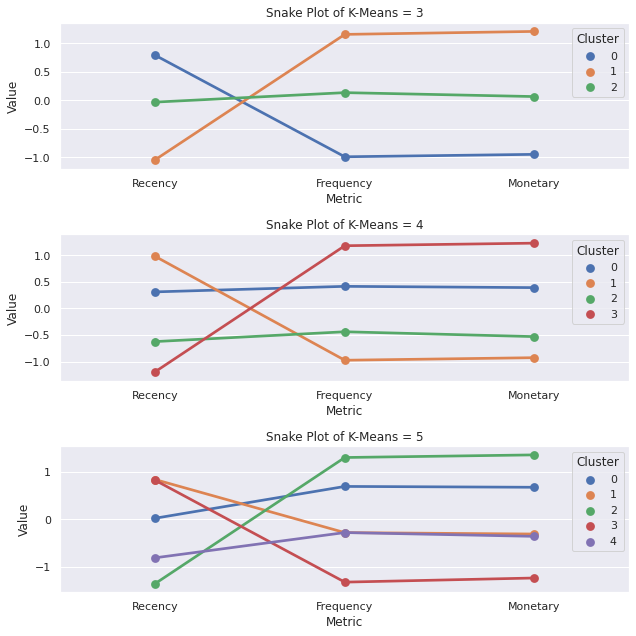

In [28]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(df_rfm_k3, transf_RFM['CustomerID'], scaled_data)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(df_rfm_k4, transf_RFM['CustomerID'], scaled_data)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(df_rfm_k5, transf_RFM['CustomerID'], scaled_data)

plt.tight_layout()

Зі згладжених графіків і графіків-змій видно, що значення кластера, що дорівнює 4, добре сегментує наших клієнтів.


4.8.З результатів кластеризації з кількістю кластерів 4 (і оригінальними значеннями RFM змінних) сформую агрегат , який містить середнє значення по кожній із трьох колонок та кількість клієнтів у кластері.


In [29]:
df_conclus= df_rfm_k4.groupby(['labels']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
df_conclus

Recency Frequency Monetary      
          mean      mean     mean count
labels                                 
0         89.0      81.0   1449.0  1130
1        197.0      15.0    294.0  1168
2         25.0      30.0    461.0   769
3         12.0     260.0   5830.0   853

Зробіть висновки про отримані результати. Як би ви назвали кожний кластер? Які з них містять користувачів, що платять, а які - тих, хто потенційно піде у відтік?

Сегментація клієнтів у випадку 4 кластерів вийшла цікавою. А саме є дві групи клієнтів, які  або недавно або давно робили останню покупку. І ці дві групи клієнтів ще в свою чергу можуть поділити на дві групи: оскільки їх частота покупок і витрачені кошти може бути або малою або високою. 

Тобто в нас є: 
1)"label=1" - група клієнтів, які дуже давно робили покупку, вони купують мало продуктів і не витратили велику суму коштів;(звичайні користувачі, які втратили зацікавленість)

2)"labels=0" - група клієнтів, які дуже давно робили покупку, але вони купують велику кількість продуктів і  витратили велику суму коштів;(постійні користувачі які є неактивними (також могли бути оптовиками))

3)"labels=2" - група клієнтів, які недавно робили покупку, вони купують мало продуктів і не витратили велику суму коштів; (нові користувачі)

4)"labels=3" -група клієнтів, які недавно робили покупку, вони купують велику кількість продуктів і витратили велику суму коштів; (постійні активні користувачі(оптовики))

Labels 0 і 3 купляли найбільше продуктів і відповідно від них і найбільший прибуток. Labels 0 і 1 давно робили покупки і вони потенційно можуть піти у відтік. Оскільки 0 ще належить до клієнтів які багато платять на це потрібно звернути увагу і прикласти зусиль щоб зацікавити і втримати клієнтів.